In [1]:
import pandas as pd
df = pd.read_excel("Original.xlsx")
mapping = {
    "Overall Positive Note": "positive",
    "Overall Negative Note": "negative",
    "Overall Neutral Note": "neutral"
}
df["Baseline"] = df["Baseline"].replace(mapping)
df.to_excel("/mnt/data/Processed.xlsx", index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.preprocessing import LabelBinarizer

# 1. Load dataset
# Assume Hypo2Processed.xlsx is in the current directory or a specified path
df = pd.read_excel('Hypo2Processed.xlsx')  # File contains columns: Baseline, Reasoning, NonReasoning
# View basic dataset info
print("Number of samples:", df.shape[0])
print("Class distribution in baseline:", df['Baseline'].value_counts().to_dict())

# 2. Define class order for consistent confusion matrix and metric calculation
classes = ['positive', 'neutral', 'negative']

# 3. Compute confusion matrices for Reasoning and Non-Reasoning models
cm_reason = confusion_matrix(df['Baseline'], df['Reasoning'], labels=classes)
cm_nonreason = confusion_matrix(df['Baseline'], df['NonReasoning'], labels=classes)

# Convert confusion matrices to DataFrames for readability
cm_reason_df = pd.DataFrame(cm_reason, index=[f"Actual_{c}" for c in classes], 
                             columns=[f"Pred_{c}" for c in classes])
cm_nonreason_df = pd.DataFrame(cm_nonreason, index=[f"Actual_{c}" for c in classes], 
                                columns=[f"Pred_{c}" for c in classes])
print("\nConfusion matrix for Reasoning model:")
print(cm_reason_df)
print("\nConfusion matrix for Non-Reasoning model:")
print(cm_nonreason_df)

# 4. Compute TP, FP, FN, TN, Precision, Recall, and F1 score per class
print("\nDetailed metrics per class for Reasoning model:")
total = len(df)
for i, cls in enumerate(classes):
    TP = cm_reason[i, i]
    FP = cm_reason[:, i].sum() - TP
    FN = cm_reason[i, :].sum() - TP
    TN = total - (TP + FP + FN)
    prec = TP / (TP + FP) if TP + FP > 0 else 0.0
    rec = TP / (TP + FN) if TP + FN > 0 else 0.0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
    print(f"Class {cls}: TP={TP}, FP={FP}, FN={FN}, TN={TN}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

print("\nDetailed metrics per class for Non-Reasoning model:")
for i, cls in enumerate(classes):
    TP = cm_nonreason[i, i]
    FP = cm_nonreason[:, i].sum() - TP
    FN = cm_nonreason[i, :].sum() - TP
    TN = total - (TP + FP + FN)
    prec = TP / (TP + FP) if TP + FP > 0 else 0.0
    rec = TP / (TP + FN) if TP + FN > 0 else 0.0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
    print(f"Class {cls}: TP={TP}, FP={FP}, FN={FN}, TN={TN}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

# 5. Compute macro/micro averages, accuracy, balanced accuracy, etc.
acc_reason = accuracy_score(df['Baseline'], df['Reasoning'])
acc_non = accuracy_score(df['Baseline'], df['NonReasoning'])
microF1_reason = f1_score(df['Baseline'], df['Reasoning'], average='micro', labels=classes)
microF1_non = f1_score(df['Baseline'], df['NonReasoning'], average='micro', labels=classes)

macroPrec_reason = precision_score(df['Baseline'], df['Reasoning'], average='macro', labels=classes, zero_division=0)
macroPrec_non = precision_score(df['Baseline'], df['NonReasoning'], average='macro', labels=classes, zero_division=0)
macroRec_reason = recall_score(df['Baseline'], df['Reasoning'], average='macro', labels=classes, zero_division=0)
macroRec_non = recall_score(df['Baseline'], df['NonReasoning'], average='macro', labels=classes, zero_division=0)
macroF1_reason = f1_score(df['Baseline'], df['Reasoning'], average='macro', labels=classes, zero_division=0)
macroF1_non = f1_score(df['Baseline'], df['NonReasoning'], average='macro', labels=classes, zero_division=0)

# Balanced accuracy = macro recall
bal_acc_reason = macroRec_reason
bal_acc_non = macroRec_non

# PR-AUC: macro-averaged one-vs-rest average precision
lb = LabelBinarizer()
lb.fit(classes)
y_true_bin = lb.transform(df['Baseline'])
y_pred_reason_bin = lb.transform(df['Reasoning'])
y_pred_non_bin = lb.transform(df['NonReasoning'])

pr_auc_macro_reason = average_precision_score(y_true_bin, y_pred_reason_bin, average='macro')
pr_auc_macro_non = average_precision_score(y_true_bin, y_pred_non_bin, average='macro')

print("\nOverall metric comparison:")
print(f"Reasoning model: Accuracy={acc_reason:.4f}, micro-F1={microF1_reason:.4f}, macro-Precision={macroPrec_reason:.4f}, "
      f"macro-Recall={macroRec_reason:.4f}, macro-F1={macroF1_reason:.4f}, Balanced Acc={bal_acc_reason:.4f}, PR-AUC(macro)={pr_auc_macro_reason:.4f}")
print(f"Non-Reasoning model: Accuracy={acc_non:.4f}, micro-F1={microF1_non:.4f}, macro-Precision={macroPrec_non:.4f}, "
      f"macro-Recall={macroRec_non:.4f}, macro-F1={macroF1_non:.4f}, Balanced Acc={bal_acc_non:.4f}, PR-AUC(macro)={pr_auc_macro_non:.4f}")

# 6. Bootstrap hypothesis test - whether metric differences between models are significant
# Define observed metric differences: Reasoning - NonReasoning
obs_diff = {
    'Accuracy': acc_reason - acc_non,
    'Macro_F1': macroF1_reason - macroF1_non,
    'Macro_Precision': macroPrec_reason - macroPrec_non,
    'Macro_Recall': macroRec_reason - macroRec_non,
    'Balanced_Accuracy': bal_acc_reason - bal_acc_non,
    'Macro_PR_AUC': pr_auc_macro_reason - pr_auc_macro_non
}
print("\nObserved metric differences (Reasoning - NonReasoning):")
for metric, diff_val in obs_diff.items():
    print(f"{metric} difference = {diff_val:.4f}")

# Perform bootstrap sampling
B = 1000  # Number of samples (can be increased for better precision)
n = df.shape[0]
diff_samples = {m: [] for m in obs_diff.keys()}
y_true = df['Baseline'].values
y_pred_reason = df['Reasoning'].values
y_pred_non = df['NonReasoning'].values

for b in range(B):
    # Sampling with replacement
    idx = np.random.randint(0, n, size=n)
    y_true_b = y_true[idx]
    y_pred_r_b = y_pred_reason[idx]
    y_pred_n_b = y_pred_non[idx]

    acc_r = np.mean(y_pred_r_b == y_true_b)
    acc_n = np.mean(y_pred_n_b == y_true_b)
    macroF1_r = f1_score(y_true_b, y_pred_r_b, average='macro', labels=classes, zero_division=0)
    macroF1_n = f1_score(y_true_b, y_pred_n_b, average='macro', labels=classes, zero_division=0)
    macroPrec_r = precision_score(y_true_b, y_pred_r_b, average='macro', labels=classes, zero_division=0)
    macroPrec_n = precision_score(y_true_b, y_pred_n_b, average='macro', labels=classes, zero_division=0)
    macroRec_r = recall_score(y_true_b, y_pred_r_b, average='macro', labels=classes, zero_division=0)
    macroRec_n = recall_score(y_true_b, y_pred_n_b, average='macro', labels=classes, zero_division=0)
    balAcc_r = macroRec_r
    balAcc_n = macroRec_n
    Y_true_b = lb.transform(y_true_b)
    Y_pred_r_b = lb.transform(y_pred_r_b)
    Y_pred_n_b = lb.transform(y_pred_n_b)
    prauc_r = average_precision_score(Y_true_b, Y_pred_r_b, average='macro')
    prauc_n = average_precision_score(Y_true_b, Y_pred_n_b, average='macro')

    diff_samples['Accuracy'].append(acc_r - acc_n)
    diff_samples['Macro_F1'].append(macroF1_r - macroF1_n)
    diff_samples['Macro_Precision'].append(macroPrec_r - macroPrec_n)
    diff_samples['Macro_Recall'].append(macroRec_r - macroRec_n)
    diff_samples['Balanced_Accuracy'].append(balAcc_r - balAcc_n)
    diff_samples['Macro_PR_AUC'].append(prauc_r - prauc_n)

# Compute 95% confidence intervals and p-values (two-tailed)
print("\nBootstrap hypothesis test results:")
alpha = 0.05
for metric, diff_list in diff_samples.items():
    arr = np.array(diff_list)
    lower = np.percentile(arr, 100 * alpha / 2)
    upper = np.percentile(arr, 100 * (1 - alpha / 2))
    prob_le0 = np.mean(arr <= 0)
    prob_ge0 = np.mean(arr >= 0)
    p_two = 2 * min(prob_le0, prob_ge0)
    sig = "Significant" if p_two < alpha else "Not significant"
    print(f"{metric}: Observed diff = {obs_diff[metric]:.4f}, 95% CI = ({lower:.4f}, {upper:.4f}), p ≈ {p_two:.4f} -> Difference is {sig}")

Number of samples: 223
Class distribution in baseline: {'neutral': 175, 'negative': 36, 'positive': 12}

Confusion matrix for Reasoning model:
                 Pred_positive  Pred_neutral  Pred_negative
Actual_positive              1            10              1
Actual_neutral               2           135             38
Actual_negative              0            12             24

Confusion matrix for Non-Reasoning model:
                 Pred_positive  Pred_neutral  Pred_negative
Actual_positive              1             8              3
Actual_neutral               0            77             98
Actual_negative              0             3             33

Detailed metrics per class for Reasoning model:
Class positive: TP=1, FP=2, FN=11, TN=209, Precision=0.3333, Recall=0.0833, F1=0.1333
Class neutral: TP=135, FP=22, FN=40, TN=26, Precision=0.8599, Recall=0.7714, F1=0.8133
Class negative: TP=24, FP=39, FN=12, TN=148, Precision=0.3810, Recall=0.6667, F1=0.4848

Detailed metrics per cl

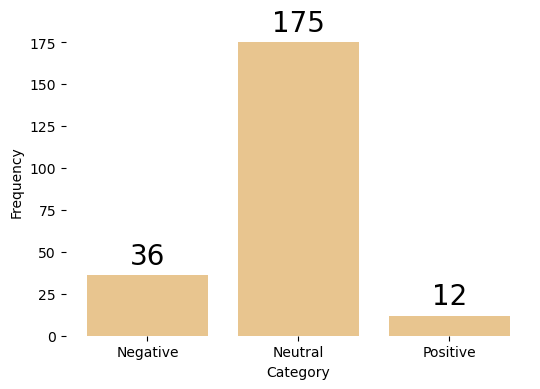

In [3]:
import matplotlib.pyplot as plt
categories = ['Negative', 'Neutral', 'Positive']
frequencies = [36, 175, 12]
plt.figure(figsize=(6, 4), facecolor='white')
bars = plt.bar(categories, frequencies, color='#e8c58f')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, int(yval), 
             ha='center', va='bottom', fontsize=20)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.box(False)
plt.show()


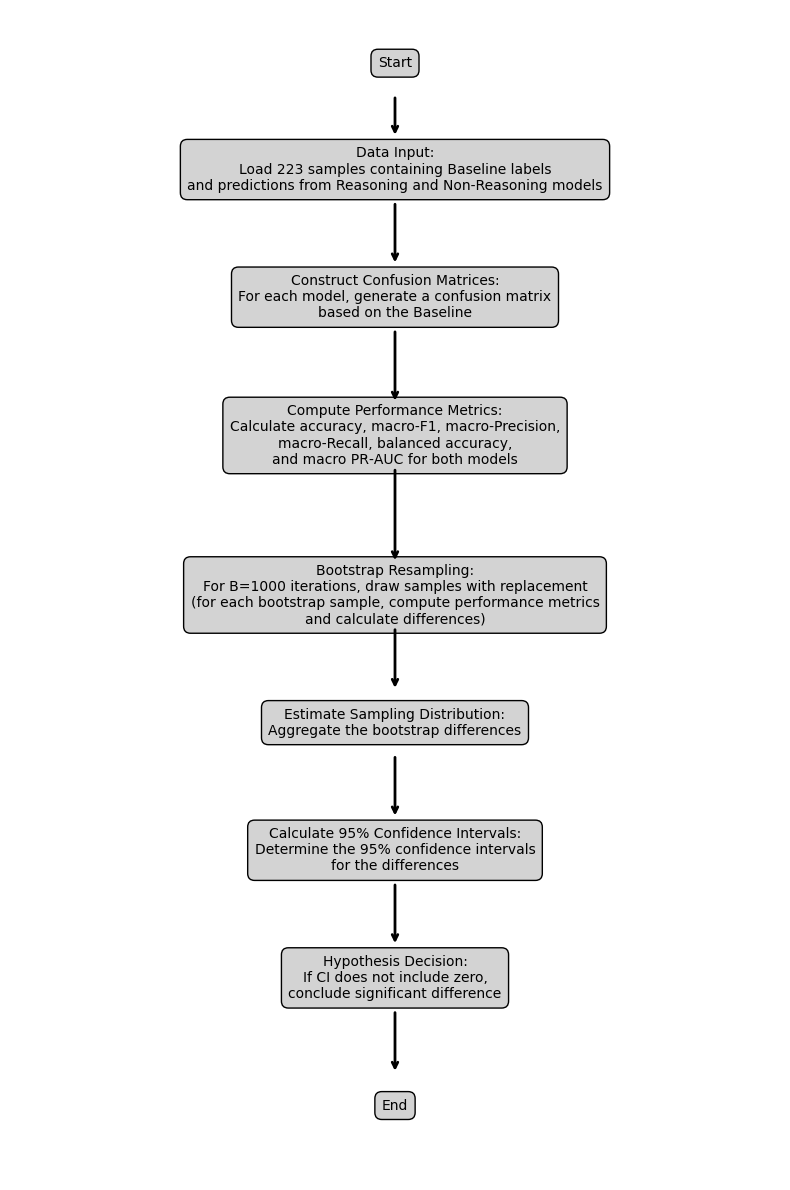

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 12))
ax = plt.gca()
ax.axis('off')

steps = [
    {'text': 'Start', 'pos': (0.5, 0.95)},
    {'text': 'Data Input:\nLoad 223 samples containing Baseline labels\nand predictions from Reasoning and Non‑Reasoning models', 'pos': (0.5, 0.85)},
    {'text': 'Construct Confusion Matrices:\nFor each model, generate a confusion matrix\nbased on the Baseline', 'pos': (0.5, 0.73)},
    {'text': 'Compute Performance Metrics:\nCalculate accuracy, macro‑F1, macro‑Precision,\nmacro‑Recall, balanced accuracy,\nand macro PR‑AUC for both models', 'pos': (0.5, 0.60)},
    {'text': 'Bootstrap Resampling:\nFor B=1000 iterations, draw samples with replacement\n(for each bootstrap sample, compute performance metrics\nand calculate differences)', 'pos': (0.5, 0.45)},
    {'text': 'Estimate Sampling Distribution:\nAggregate the bootstrap differences', 'pos': (0.5, 0.33)},
    {'text': 'Calculate 95% Confidence Intervals:\nDetermine the 95% confidence intervals\nfor the differences', 'pos': (0.5, 0.21)},
    {'text': 'Hypothesis Decision:\nIf CI does not include zero,\nconclude significant difference', 'pos': (0.5, 0.09)},
    {'text': 'End', 'pos': (0.5, -0.03)}
]

for step in steps:
    plt.text(step['pos'][0], step['pos'][1], step['text'],
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

for i in range(len(steps)-1):
    start = steps[i]['pos']
    end = steps[i+1]['pos']
    plt.annotate("",
                 xy=(end[0], end[1] + 0.03),  
                 xytext=(start[0], start[1] - 0.03), 
                 arrowprops=dict(arrowstyle="->", lw=2))

plt.xlim(0, 1)
plt.ylim(-0.1, 1)
plt.tight_layout()
plt.show()


Original Counts: {'positive': 12, 'neutral': 175, 'negative': 36}


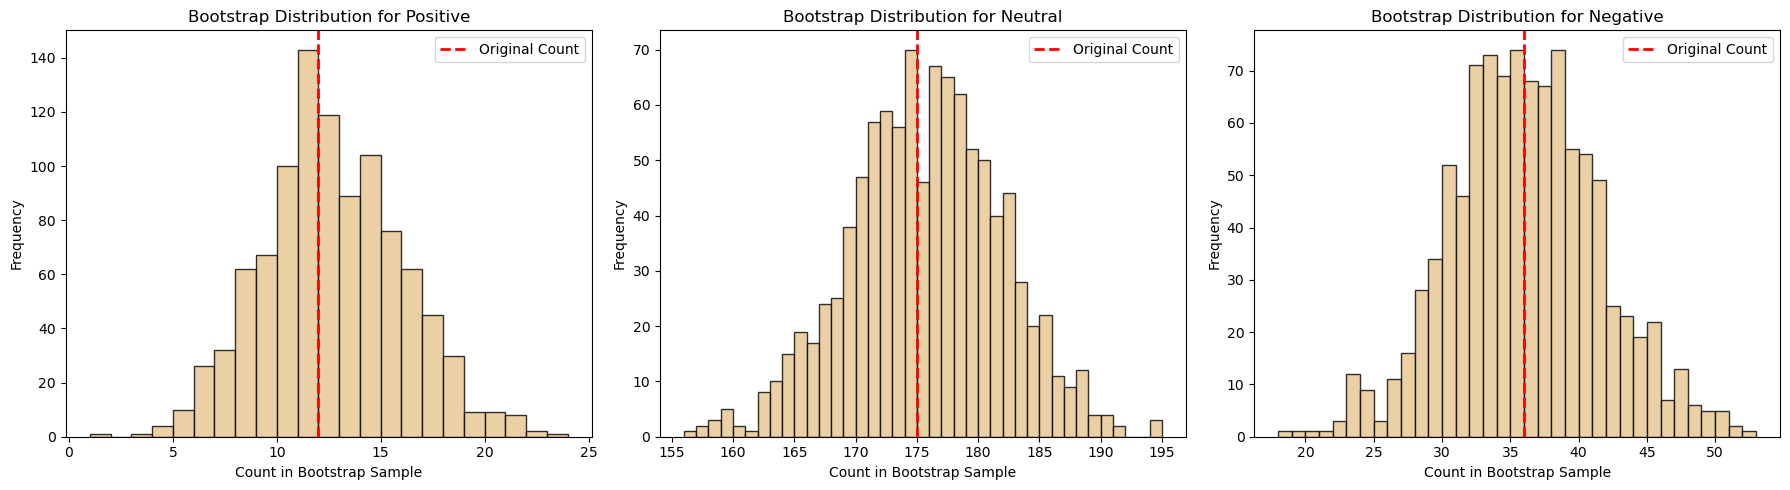

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data from the Excel file
df = pd.read_excel('Hypo2Processed.xlsx')
y_true = df['Baseline'].values
n = len(y_true)

# Compute original class counts
original_counts = {
    'positive': np.sum(y_true == 'positive'),
    'neutral': np.sum(y_true == 'neutral'),
    'negative': np.sum(y_true == 'negative')
}

print("Original Counts:", original_counts)  # Expected: positive=12, neutral=175, negative=36

# Number of bootstrap iterations
B = 1000

# Initialize lists to store bootstrap counts for each class
bootstrap_counts_pos = []
bootstrap_counts_neu = []
bootstrap_counts_neg = []

# Perform bootstrap resampling
for b in range(B):
    # Draw a bootstrap sample with replacement of size n
    idx = np.random.randint(0, n, size=n)
    y_boot = y_true[idx]
    bootstrap_counts_pos.append(np.sum(y_boot == 'positive'))
    bootstrap_counts_neu.append(np.sum(y_boot == 'neutral'))
    bootstrap_counts_neg.append(np.sum(y_boot == 'negative'))

# Plot histograms for each class separately
classes = ['positive', 'neutral', 'negative']
bootstrap_counts = [bootstrap_counts_pos, bootstrap_counts_neu, bootstrap_counts_neg]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, cls in enumerate(classes):
    ax = axes[i]
    counts = bootstrap_counts[i]
    # Plot histogram of bootstrap counts for the class
    ax.hist(counts, bins=range(min(counts), max(counts) + 2),
            color='#e8c58f', edgecolor='black', alpha=0.8)
    # Mark the original count as a dashed red line
    ax.axvline(original_counts[cls], color='red', linestyle='dashed', linewidth=2, label='Original Count')
    ax.set_title(f'Bootstrap Distribution for {cls.capitalize()}')
    ax.set_xlabel('Count in Bootstrap Sample')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()
